In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import scanpy as sc
import torch
import scarches as sca
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sc.set_figure_params(dpi=200, frameon=False, figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Download Dataset and split into reference dataset and query dataset

In [4]:
adata = sc.read('pbmc_vars_sb.h5ad')

In [5]:
adata = adata[adata.obs['study']!='Villani'].copy()

In [6]:
adata.X = adata.layers["counts"].copy()

In [7]:
sca.add_annotations(adata, 'c2.cp.reactome.v4.0.symbols.gmt', min_genes=12)

In [8]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [9]:
sc.pp.normalize_total(adata)

In [10]:
sc.pp.log1p(adata)

In [11]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

In [12]:
select_terms = adata.varm['I'].sum(0)>12

In [13]:
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()

In [14]:
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [15]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [16]:
adata.X = adata.layers["counts"].copy()

### Create TRVAE model and train it on reference dataset

In [17]:
intr_cvae = sca.models.TRVAE(
    adata=adata,
    condition_key='study',
    hidden_layer_sizes=[256, 256, 256],
    use_mmd=False,
    recon_loss='nb',
    mask=adata.varm['I'].T,
    use_decoder_relu=False,
    mmd_instead_kl=False,
    use_l_encoder=True
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 256 4
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 282
Encoder Architecture:
	Input Layer in, out and cond: 1972 128 4
	Mean/Var Layer in/out: 128 1
Decoder Architecture:
	Masked linear layer in, out and cond:  282 1972 4


In [18]:
ALPHA = 0.7

In [19]:
OMEGA = None

In [20]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=400, 
    alpha_epoch_anneal=100, 
    alpha=ALPHA, 
    omega=OMEGA,
    alpha_kl=0.5,
    weight_decay=0., 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    seed=2020
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |███████-------------| 37.8%  - epoch_loss:  878.94 - epoch_recon_loss:  854.90 - epoch_kl_loss:   48.08 - val_loss:  939.48 - val_recon_loss:  914.98 - val_kl_loss:   49.01
ADJUSTED LR
 |█████████-----------| 47.8%  - epoch_loss:  876.98 - epoch_recon_loss:  852.92 - epoch_kl_loss:   48.10 - val_loss:  940.42 - val_recon_loss:  915.70 - val_kl_loss:   49.44
ADJUSTED LR
 |██████████----------| 51.5%  - epoch_loss:  878.31 - epoch_recon_loss:  854.29 - epoch_kl_loss:   48.05 - val_loss:  935.66 - val_recon_loss:  910.98 - val_kl_loss:   49.36
ADJUSTED LR
 |██████████----------| 54.8%  - epoch_loss:  877.33 - epoch_recon_loss:  853.29 - epoch_kl_loss:   48.10 - val_loss:  933.93 - val_recon_loss:  909.30 - val_kl_loss:   49.25
ADJUSTED LR
 |███████████---------| 58.0%  - epoch_loss:  875.15 - epoch_recon_loss:  851.18 - epoch_kl_loss:   47.95 - val_loss:  936.54 - val_recon_loss:  911.88 - val_kl_loss:   49.31
ADJUSTED LR
 |████████████--------| 60.8%  - epoch_loss:  878.79 - epoch_reco

In [21]:
inactive_idx = ~(intr_cvae.model.decoder.L0.expr_L.weight.data.norm(p=2, dim=0)>0).cpu().numpy()

In [22]:
print('Inactive terms:')
[term for i, term in enumerate(adata.uns['terms']) if inactive_idx[i]]

Inactive terms:


['O_LINKED_GLYCOSYLATION_OF_MUCI',
 'NUCLEAR_SIGNALING_BY_ERBB4',
 'PRE_NOTCH_TRANSCRIPTION_AND_TR',
 'CIRCADIAN_REPRESSION_OF_EXPRES',
 'SIGNALLING_TO_RAS',
 'SMAD2_SMAD3_SMAD4_HETEROTRIMER',
 'PI_METABOLISM',
 'HEPARAN_SULFATE_HEPARIN_HS_GAG',
 'BASIGIN_INTERACTIONS',
 'TRANSLOCATION_OF_ZAP_70_TO_IMM',
 'TRANSPORT_OF_MATURE_TRANSCRIPT',
 'REGULATION_OF_APOPTOSIS',
 'PHASE1_FUNCTIONALIZATION_OF_CO',
 'RNA_POL_II_TRANSCRIPTION_PRE_I',
 'SEMA4D_INDUCED_CELL_MIGRATION_',
 'CD28_DEPENDENT_PI3K_AKT_SIGNAL',
 'CTLA4_INHIBITORY_SIGNALING',
 'SMOOTH_MUSCLE_CONTRACTION',
 'ACTIVATION_OF_NMDA_RECEPTOR_UP',
 'CELL_JUNCTION_ORGANIZATION',
 'PHOSPHOLIPASE_C_MEDIATED_CASCA',
 'ACTIVATION_OF_KAINATE_RECEPTOR',
 'ACTIVATED_TAK1_MEDIATES_P38_MA',
 'DEPOSITION_OF_NEW_CENPA_CONTAI',
 'IL_RECEPTOR_SHC_SIGNALING',
 'TRAF6_MEDIATED_NFKB_ACTIVATION',
 'ION_TRANSPORT_BY_P_TYPE_ATPASE',
 'PLATELET_AGGREGATION_PLUG_FORM',
 'PACKAGING_OF_TELOMERE_ENDS']

In [23]:
MEAN = False

In [24]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [25]:
sc.pp.neighbors(adata, use_rep='X_cvae')

In [26]:
sc.tl.umap(adata)

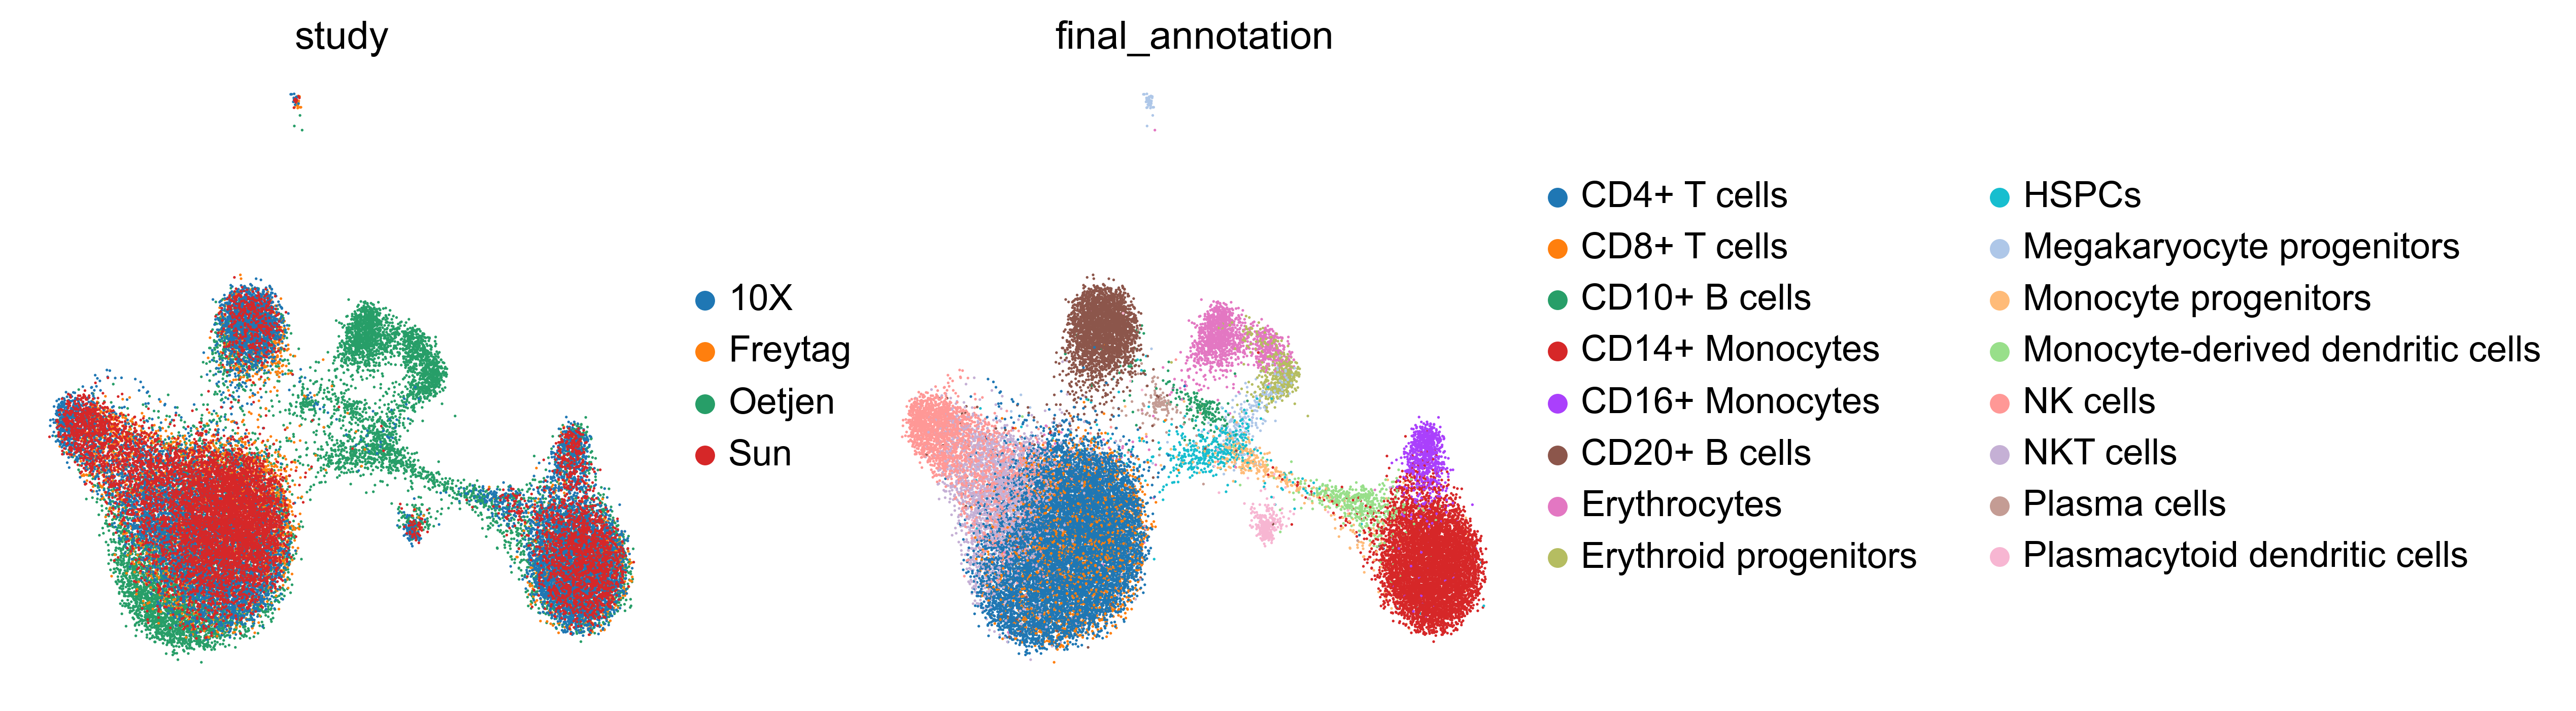

In [27]:
sc.pl.umap(adata, color=['study', 'final_annotation'], frameon=False)

In [28]:
#intr_cvae.save('intr_cvae_nb_mmd_beta_15')

In [29]:
covid = sc.read('covid_pbmc.h5ad')
covid.var_names_make_unique()
covid = covid[:, adata.var_names].copy()
covid.X = covid.X.toarray()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [30]:
covid.obs['batch_covid'] = covid.obs['batch']

In [31]:
covid.obs['study'] = 'Covid'

In [32]:
kang = sc.read('kang_count.h5ad')[:, adata.var_names].copy()

In [33]:
kang.obs['study'] = 'Kang'

In [34]:
covid_kang = sc.AnnData.concatenate(covid, kang, batch_key='batch_join')

In [31]:
#q_intr_cvae = sca.models.TRVAE.load('q_intr_cvae_nb_alpha_kl_0_001_sd_2021', kang)

In [35]:
q_intr_cvae = sca.models.TRVAE.load_query_data(covid_kang, intr_cvae)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 256 6
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 282
Encoder Architecture:
	Input Layer in, out and cond: 1972 128 6
	Mean/Var Layer in/out: 128 1
Decoder Architecture:
	Masked linear layer in, out and cond:  282 1972 6


In [36]:
q_intr_cvae.train(n_epochs=200, alpha_epoch_anneal=30, weight_decay=0., alpha_kl=0.001, seed=2020, use_early_stopping=True)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |█████---------------| 29.5%  - epoch_loss:  524.12 - epoch_recon_loss:  524.05 - epoch_kl_loss:   75.09 - val_loss:  524.32 - val_recon_loss:  524.24 - val_kl_loss:   74.29
ADJUSTED LR
 |██████--------------| 34.5%  - epoch_loss:  524.33 - epoch_recon_loss:  524.26 - epoch_kl_loss:   75.05 - val_loss:  524.55 - val_recon_loss:  524.48 - val_kl_loss:   74.47
ADJUSTED LR
 |████████------------| 40.0%  - epoch_loss:  521.68 - epoch_recon_loss:  521.61 - epoch_kl_loss:   74.87 - val_loss:  524.77 - val_recon_loss:  524.69 - val_kl_loss:   74.37
ADJUSTED LR
 |████████------------| 43.5%  - epoch_loss:  525.70 - epoch_recon_loss:  525.63 - epoch_kl_loss:   75.03 - val_loss:  523.34 - val_recon_loss:  523.26 - val_kl_loss:   74.44
ADJUSTED LR
 |█████████-----------| 46.5%  - epoch_loss:  520.70 - epoch_recon_loss:  520.63 - epoch_kl_loss:   74.86 - val_loss:  522.54 - val_recon_loss:  522.47 - val_kl_loss:   74.37
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early 

In [76]:
#q_intr_cvae.save('q_intr_cvae_covid__kang_pbmc_le_alpha_kl_0_5_0_001_sd_2020')

In [37]:
covid_kang.obsm['X_cvae'] = q_intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [38]:
sc.pp.neighbors(covid_kang, use_rep='X_cvae')

In [39]:
sc.tl.umap(covid_kang)

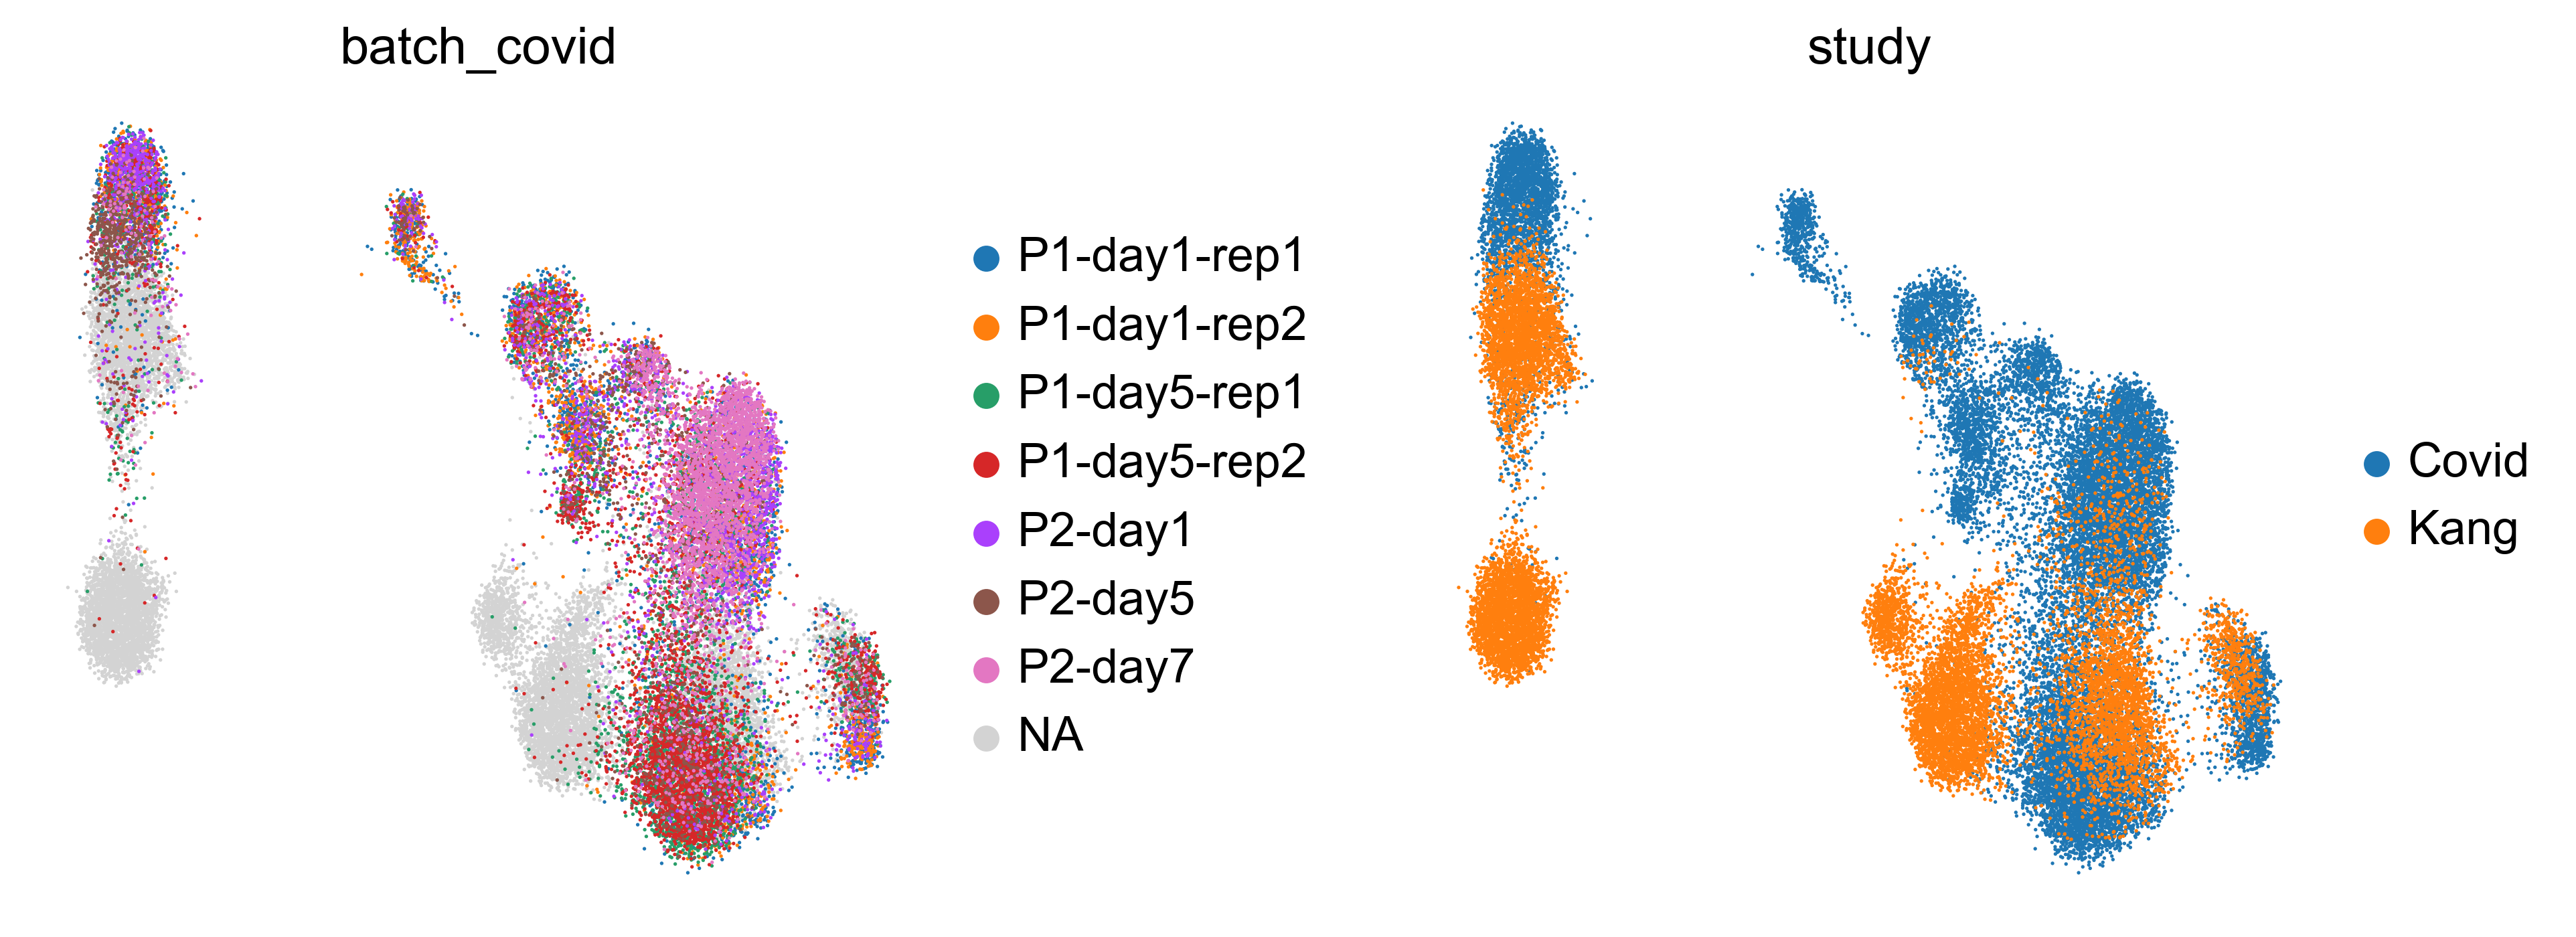

In [45]:
sc.pl.umap(covid_kang, color=['batch_covid', 'study'], wspace=0.4)

In [42]:
covid_pbmc = sc.AnnData.concatenate(adata, covid_kang, batch_key='batch_join')

In [43]:
covid_pbmc.obsm['X_cvae'] = q_intr_cvae.get_latent(covid_pbmc.X, covid_pbmc.obs['study'], mean=MEAN)[:, ~inactive_idx]

In [44]:
sc.pp.neighbors(covid_pbmc, use_rep='X_cvae')
sc.tl.umap(covid_pbmc)

In [46]:
covid_pbmc.strings_to_categoricals()

... storing 'batch' as categorical
... storing 'chemistry' as categorical
... storing 'data_type' as categorical
... storing 'final_annotation' as categorical
... storing 'sample_ID' as categorical
... storing 'species' as categorical
... storing 'study' as categorical
... storing 'tissue' as categorical
... storing 'batch2' as categorical
... storing 'batch_covid' as categorical
... storing 'orig.ident' as categorical
... storing 'stim' as categorical
... storing 'seurat_annotations' as categorical
... storing 'condition' as categorical
... storing 'cell_type' as categorical


In [53]:
covid_pbmc.obs['cell_type_joint'] = covid_pbmc.obs['final_annotation'].tolist()

In [54]:
covid_pbmc.obs['cell_type_joint'][covid_pbmc.obs.study == 'Kang'] = covid_pbmc.obs.cell_type

In [58]:
celltypes_replace = {}
celltypes_replace['CD20+ B cells'] = 'B'
celltypes_replace['CD4 T'] = 'CD4+ T cells'
celltypes_replace['CD8 T'] = 'CD8+ T cells'
celltypes_replace['CD14 Mono'] = 'CD14+ Monocytes'
celltypes_replace['CD16 Mono'] = 'CD16+ Monocytes'
celltypes_replace['NK'] = 'NK cells'

In [62]:
categories = np.unique(covid_pbmc.obs['cell_type_joint'].astype(str))
for cat in categories:
    if cat in celltypes_replace:
        covid_pbmc.obs['cell_type_joint'][covid_pbmc.obs['cell_type_joint']==cat] = celltypes_replace[cat]

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
clf = RandomForestClassifier(
    random_state=1,
    class_weight = "balanced_subsample",
    verbose=1,
    n_jobs=-1,
)

mask_train = (covid_pbmc.obs.study != 'Covid') & ~covid_pbmc.obs.cell_type_joint.isin(['DC', 'T'])
adata_train = covid_pbmc[mask_train]

X_train = adata_train.obsm['X_cvae']
y_train = adata_train.obs['cell_type_joint'].to_numpy()

clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.1s finished


RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-1,
                       random_state=1, verbose=1)

In [68]:
predict = clf.predict(covid_pbmc[covid_pbmc.obs.study == 'Covid'].obsm['X_cvae'])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [69]:
covid_pbmc.obs['cell_type_joint'][covid_pbmc.obs.study == 'Covid'] = predict

... storing 'cell_type_joint' as categorical


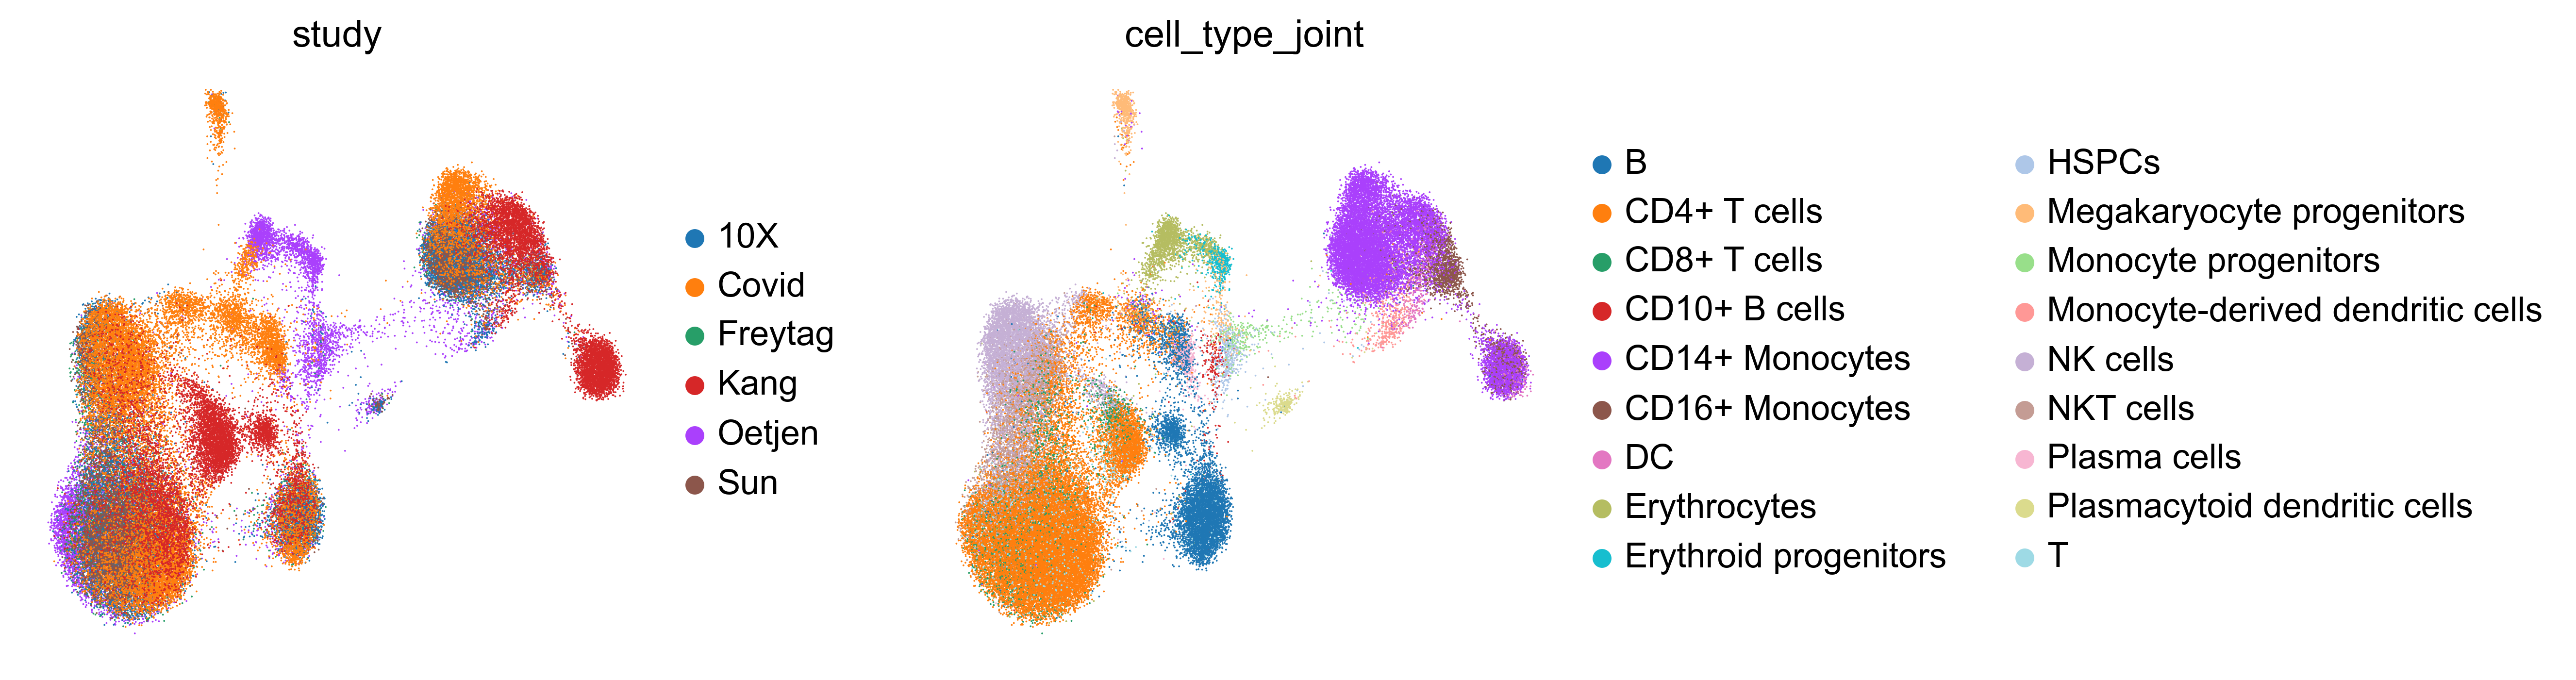

In [71]:
sc.pl.umap(covid_pbmc, color=['study', 'cell_type_joint'], wspace=0.3)

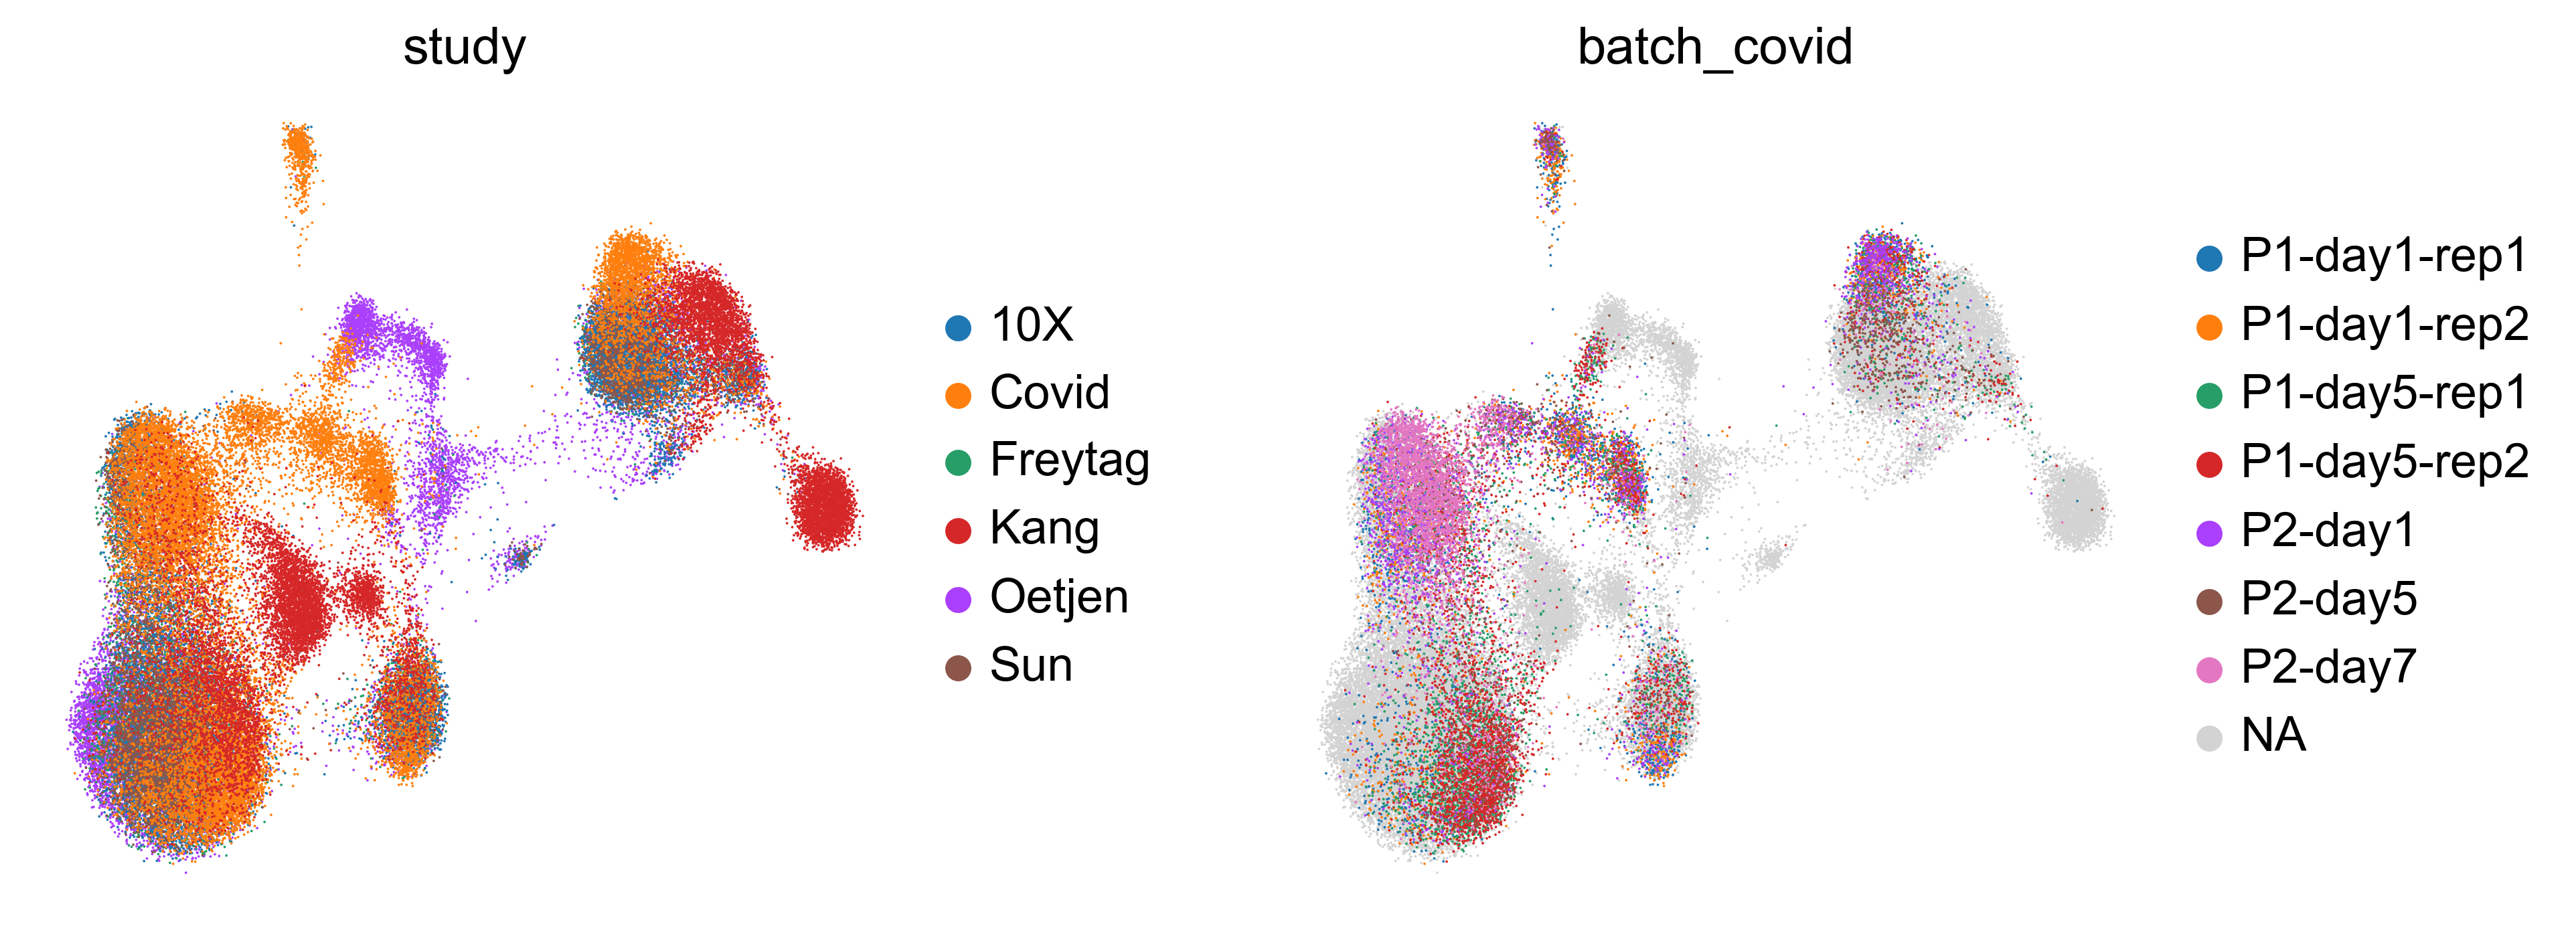

In [72]:
sc.pl.umap(covid_pbmc, color=['study', 'batch_covid'], wspace=0.3)

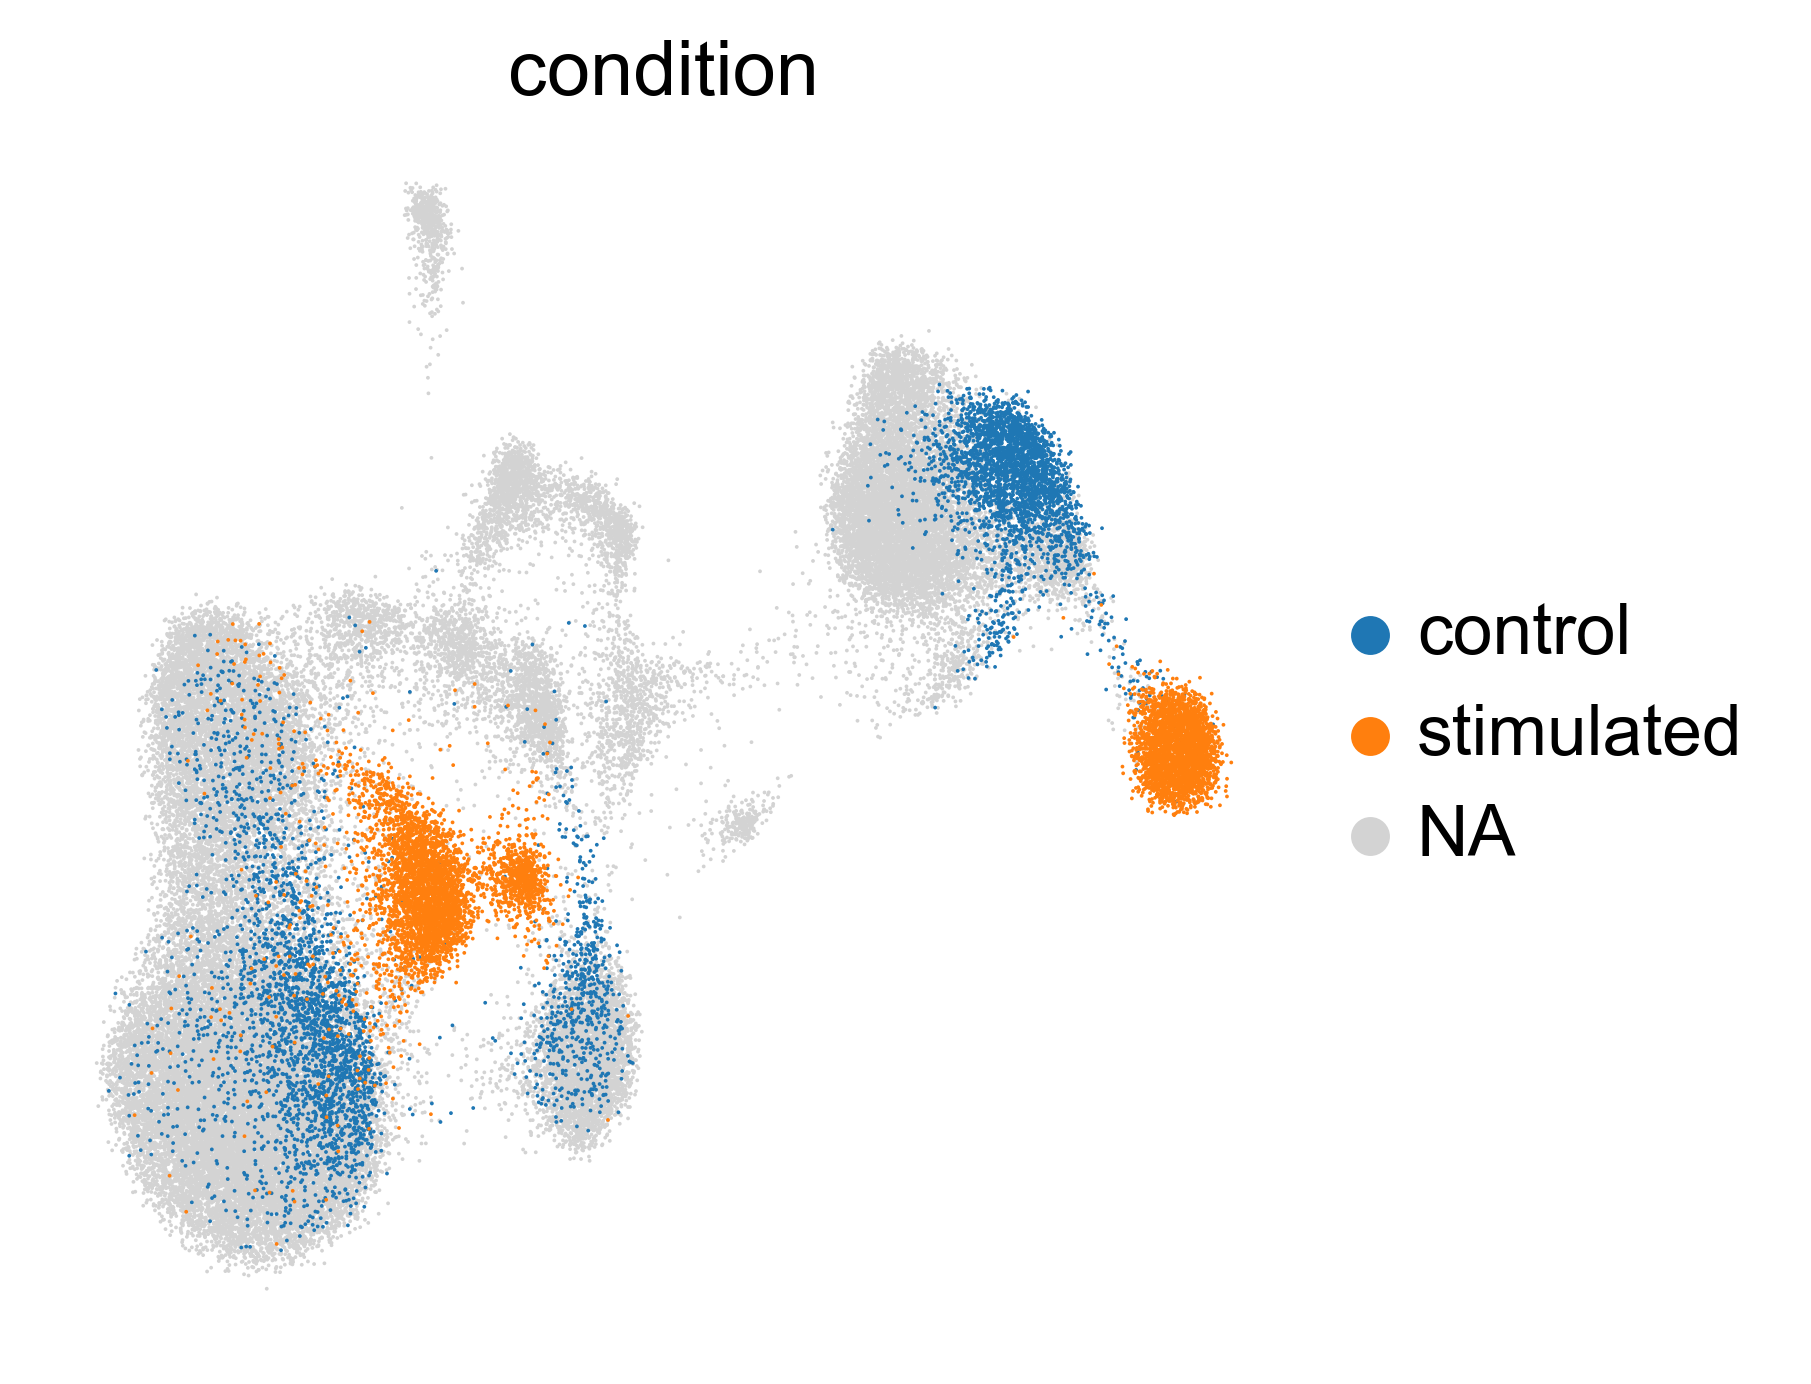

In [73]:
sc.pl.umap(covid_pbmc, color='condition')

In [74]:
covid_pbmc.uns['terms'] = adata.uns['terms']

In [75]:
#covid_pbmc.write('covid_kang_pbmc_integrated_le.h5ad')